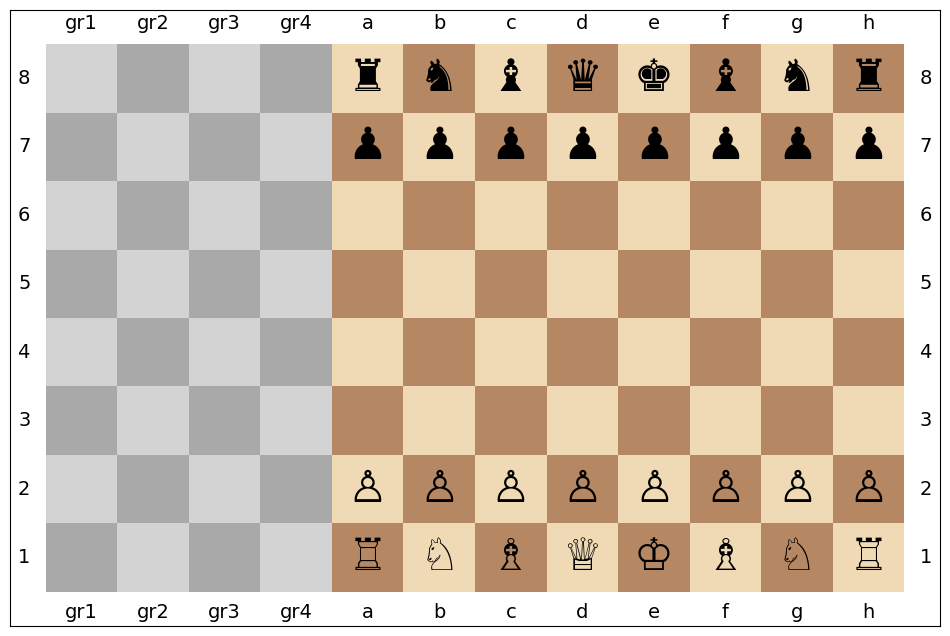

In [361]:
import requests
from time import sleep
import matplotlib.pyplot as plt

import websocket
import json

#websocket url
MOONRAKER_WS_URL = "ws://autochess:7125/websocket"
ws = websocket.WebSocket()

request_counter = 0

#send gcode using moon raker
def send_gcode(ws, command):
    global request_counter
    payload = {
        "jsonrpc": "2.0",
        "method": "printer.gcode.script",
        "params": {"script": command},
        "id": request_counter
    }
    ws.send(json.dumps(payload))
    print(f"Sent G-code: {command} (id: {request_counter})")

    gcode_responses = []

    #poll for response
    while True:
        message = ws.recv()
        data = json.loads(message)

        # get gcode response
        if data.get("method") == "notify_gcode_response":
            gcode_responses.append(data["params"][0])
            continue
        
        #got command response
        if data.get("id") == request_counter:
            print("\nCommand acknowledged:")
            print(json.dumps(data, indent=4))
            break

    if gcode_responses:
        print("\nG-code response(s):")
        for line in gcode_responses:
            print(line)
    else:
        print("\nNo G-code response received.")

    request_counter += 1


# Initialize boardState with first four columns empty
boardState = []

def resetBoard():
    global boardState
    boardState = [
        ["", "", "", "", "r", "n", "b", "q", "k", "b", "n", "r"],
        ["", "", "", "", "p", "p", "p", "p", "p", "p", "p", "p"],
        ["", "", "", "", "", "", "", "", "", "", "", ""],
        ["", "", "", "", "", "", "", "", "", "", "", ""],
        ["", "", "", "", "", "", "", "", "", "", "", ""],
        ["", "", "", "", "", "", "", "", "", "", "", ""],
        ["", "", "", "", "P", "P", "P", "P", "P", "P", "P", "P"],
        ["", "", "", "", "R", "N", "B", "Q", "K", "B", "N", "R"]
    ]

graveyardCount = 0

resetBoard()

# Unicode chess piece symbols
piece_symbols = {
    "r": "♜", "n": "♞", "b": "♝", "q": "♛", "k": "♚", "p": "♟",
    "R": "♖", "N": "♘", "B": "♗", "Q": "♕", "K": "♔", "P": "♙",
    "": ""
}


def drawBoard():
    fig, ax = plt.subplots(figsize=(12, 8))  # Wider board to accommodate 12 columns
    colors = ["#F0D9B5", "#B58863"]  # Light and dark squares
    graveyard_colors = ["#D3D3D3", "#A9A9A9"]  # Light grey and dark grey for graveyard squares

    num_cols = len(boardState[0])  # 12 columns
    num_rows = len(boardState)    # 8 rows

    # Draw squares and pieces
    for row in range(num_rows):
        for col in range(num_cols):
            if col < 4:  # First 4 columns are graveyard
                color = graveyard_colors[(row + col) % 2]  # Checkerboard pattern for graveyard
            else:
                color = colors[(row + col) % 2]  # Alternate colors
            rect = plt.Rectangle((col, 7 - row), 1, 1, facecolor=color)
            ax.add_patch(rect)
            # Draw piece if it exists
            piece = boardState[row][col]
            if piece:
                ax.text(col + 0.5, 7 - row + 0.5, piece_symbols[piece], fontsize=32,
                        ha='center', va='center')

    # Custom file labels (for 12 columns)
    files = ['gr1', 'gr2', 'gr3', 'gr4', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']  # First 4 empty, then standard files
    for i in range(num_cols):
        ax.text(i + 0.5, -0.3, files[i], ha='center', va='center', fontsize=14)  # bottom
        ax.text(i + 0.5, 8.3, files[i], ha='center', va='center', fontsize=14)   # top

    # Add rank numbers (1-8) on sides
    ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
    for i in range(num_rows):
        ax.text(-0.3, i + 0.5, ranks[7 - i], ha='center', va='center', fontsize=14)  # left
        ax.text(num_cols + 0.3, i + 0.5, ranks[7 - i], ha='center', va='center', fontsize=14)  # right

    # Set board limits and hide axes
    ax.set_xlim(-0.5, num_cols + 0.5)
    ax.set_ylim(-0.5, 8.5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


# Draw the board
drawBoard()

def chessCoordToArrayCoord(coord):
    if len(coord) == 2:
        file = coord[0]
        rank = coord[1]
        col = ord(file) - ord('a') + 4  # Adjust for 4 graveyard columns
        row = 8 - int(rank)
    else:
        file = coord[2]
        rank = coord[3]
        col = int(rank) - 1
        row = 8 - int(file)
        return [row, col]

    return [row, col]

def chessCoordToPhysicalCoord(coord):
    arrX, arrY = chessCoordToArrayCoord(coord)

    diffX = 7 - arrX
    diffY = 11 - arrY

    phyX =  28 + diffX * 38
    phyY = 20 + diffY * 38

    return phyX, phyY

#change to moonraker later
def sendCoordMove(coord):
    x, y = chessCoordToPhysicalCoord(coord)
    gcode = f'_CLIENT_LINEAR_MOVE X={x} Y={y} F=3900 ABSOLUTE=1'
    print(gcode) 
             
    send_gcode(ws, gcode)

def sendTileDeltaMove(delta,direction):
    delta = 38 * delta
    
    if direction == "n":
        x = delta
        y = 0
    elif direction == "s":
        x = -delta
        y = 0
    elif direction == "e":
        x = 0
        y = delta
    elif direction == "w":
        x = 0
        y = -delta
    
    gcode = f'_CLIENT_LINEAR_MOVE X={x} Y={y} F=3900 ABSOLUTE=0'
    
    send_gcode(ws, gcode)    

#also change to moonraker
def activateMagnet(active):
    klipper_url = 'http://192.168.40.161:7125/printer/gcode/script'
    
    if active:
        send_gcode(ws, "MAG_ON")
    else:
        send_gcode(ws, "MAG_OFF")

#home
def home():
    send_gcode(ws, "custom_home")

def graveCountToArrayCoord(graveCount):
    
    row = (graveCount - 1) // 4 + 1  # Calculate row number
    col = (graveCount - 1) % 4 + 1   # Calculate column number

    coord = chessCoordToArrayCoord(f"gr{row}{col}")
    
    return coord

def updateboardState(start, end, graveyard=False):
    print(start, end)
    startCoord = chessCoordToArrayCoord(start)

    if not graveyard:
        endCoord = chessCoordToArrayCoord(end)
    else:
        endCoord =  graveCountToArrayCoord(end)

    boardState[endCoord[0]][endCoord[1]] = boardState[startCoord[0]][startCoord[1]]
    boardState[startCoord[0]][startCoord[1]] = ""

def moveToGraveyard(coord):
    sendCoordMove(coord)
    sleep(0.5)
    activateMagnet(True)
    
    pieceRow, pieceCol = chessCoordToArrayCoord(coord)

    print(pieceRow, pieceCol)

    global graveyardCount
    graveyardCount += 1
    graveRow, graveCol = graveCountToArrayCoord(graveyardCount)

    print(graveRow, graveCol)

    if pieceRow > 3:
        # move backwards half a tile
        sendTileDeltaMove(0.5,"s")
        offset = 0.5
    else:
        # move forward half a tile
        sendTileDeltaMove(0.5,"n")
        offset = -0.5

    eastSlide = (pieceCol - graveCol - 0.5)

    sendTileDeltaMove(eastSlide,"e")

    northSouthSlide = (pieceRow - graveRow + offset)
    print(northSouthSlide)

    sendTileDeltaMove(northSouthSlide,"n")
    sendTileDeltaMove(0.5,"e")

    activateMagnet(False)

    updateboardState(coord, graveyardCount, graveyard=True)

    # return graveRow, graveCol

def processMove(move):
    start = move[:2]
    end = move[2:]

    #array position of start
    arrayPosStart = chessCoordToArrayCoord(start)
    pieceType = boardState[arrayPosStart[0]][arrayPosStart[1]].lower()

    print(pieceType)

    if pieceType == '':
        print('NO PIECE')
        return

    #check for capture
    arrayPosEnd = chessCoordToArrayCoord(end)
    finalPosType = boardState[arrayPosEnd[0]][arrayPosEnd[1]].lower()

    if finalPosType != '':
        print('CAPTURE')
        moveToGraveyard(end)
    else:
        print('NO CAPTURE')

    #check for knight
    if pieceType == 'n':
        #check direction of move
        # Calculate difference
        dx = arrayPosEnd[0] - arrayPosStart[0]
        dy = arrayPosEnd[1] - arrayPosStart[1]

        if abs(dx) == 2:
            majorDirection = "n" if dx < 0 else "s"
            minorDirection = "w" if dy > 0 else "e"
        else:
            majorDirection = "e" if dy < 0 else "w"
            minorDirection = "n" if dx < 0 else "s"
        
        sendCoordMove(start)
        sleep(0.5)
        activateMagnet(True)
        sleep(0.5)
        sendTileDeltaMove(0.5,minorDirection)
        sendTileDeltaMove(2,majorDirection)
        sendTileDeltaMove(0.5,minorDirection)
        activateMagnet(False)
    else:
        sendCoordMove(start)
        sleep(0.5)
        activateMagnet(True)
        sleep(0.5)
        sendCoordMove(end)
        activateMagnet(False)

    updateboardState(start, end)
    drawBoard()

def recenterPieces():
    moves = ['h8', 'g8', 'f8', 'e8', 'd8', 'c8', 'b8', 'a8', 'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7']

    for move in moves:
        print(move)
        sendCoordMove(move)
        sleep(3)
        print('Activating magnet')
        activateMagnet(True)
        sleep(0.5)
        print('Deactivating magnet')
        activateMagnet(False)
        sleep(0.5)




In [ ]:
print("Connecting to Moonraker...")
ws.connect(MOONRAKER_WS_URL)
print("Connected to Moonraker WebSocket")

sendCoordMove("h8")


print("Exiting. Closing WebSocket...")
ws.close()

Connecting to Moonraker...
Connected to Moonraker WebSocket
_CLIENT_LINEAR_MOVE X=294 Y=20 F=3900 ABSOLUTE=1
Sent G-code: _CLIENT_LINEAR_MOVE X=294 Y=20 F=3900 ABSOLUTE=1 (id: 13)

Command acknowledged:
{
    "jsonrpc": "2.0",
    "result": "ok",
    "id": 13
}

No G-code response received.
Exiting. Closing WebSocket...
